# Application of Deep Learning Algorithms for S&P 500 Stock Prices Prediction

## Imports

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Explorative Data Analysis

### Parsing
Historical Data of the S&P 500 index were downloaded from: https://www.nasdaq.com/de/market-activity/index/spx/historical.

In [78]:
# Read in CSV from directory
df = pd.read_csv('data/historical_data_sp_500.csv', sep=',', parse_dates=['Datum'], index_col='Datum')

In [79]:
# Verify shape of dataframe
df.shape

(2554, 5)

In [80]:
# Rename index column
df.index.names = ['date']


In [81]:
# Rename feature columns
df.rename(columns={'Schluss/Letzter':'close', 'Volumen':'volume', 'Eröffnungskurs':'open', 'Hoch':'high', 'Tief':'low'}, inplace=True)

In [82]:
# Show first few rows
df.head(n=5)

,close,volume,open,high,low
date,,,,,
2022-01-03,4796.56,--,4778.14,4796.64,4758.17
2021-12-31,4766.18,--,4775.21,4786.83,4765.75
2021-12-30,4778.73,--,4794.23,4808.93,4775.33
2021-12-29,4793.06,--,4788.64,4804.06,4778.08
2021-12-28,4786.35,--,4795.49,4807.02,4780.04


In [83]:
# Show last few rows
df.tail(n=5)

,close,volume,open,high,low
date,,,,,
2012-01-10,1292.08,--,1280.77,1296.46,1280.77
2012-01-09,1280.70,--,1277.83,1281.99,1274.55
2012-01-06,1277.81,--,1280.93,1281.84,1273.34
2012-01-05,1281.06,--,1277.30,1283.05,1265.26
2012-01-04,1277.30,--,1277.03,1278.73,1268.10


In [84]:
# It seems that the latest dates are on top of the dataframe. However, we want it to be reverse
df = df.iloc[::-1]

In [85]:
df.head(n=5)

,close,volume,open,high,low
date,,,,,
2012-01-04,1277.30,--,1277.03,1278.73,1268.10
2012-01-05,1281.06,--,1277.30,1283.05,1265.26
2012-01-06,1277.81,--,1280.93,1281.84,1273.34
2012-01-09,1280.70,--,1277.83,1281.99,1274.55
2012-01-10,1292.08,--,1280.77,1296.46,1280.77


In [86]:
df.tail(n=5)

,close,volume,open,high,low
date,,,,,
2021-12-28,4786.35,--,4795.49,4807.02,4780.04
2021-12-29,4793.06,--,4788.64,4804.06,4778.08
2021-12-30,4778.73,--,4794.23,4808.93,4775.33
2021-12-31,4766.18,--,4775.21,4786.83,4765.75
2022-01-03,4796.56,--,4778.14,4796.64,4758.17


### Verification of the data types

In [87]:
df.dtypes

close     float64
volume     object
open      float64
high      float64
low       float64
dtype: object

In [88]:
# The volume is not present for any row --> let's remove this column
df = df.drop('volume', axis=1)

### Analysis of duplicates

In [89]:
df.duplicated().any()

True

In [90]:
df[df.duplicated(keep=False)].head(n=10)

,close,open,high,low
date,,,,
2012-10-29,1411.94,0.0,0.0,0.0
2012-10-30,1411.94,0.0,0.0,0.0


In [91]:
# Show these two data points --> they have both missing values
df.loc['2012-10-28':'2012-10-30']

,close,open,high,low
date,,,,
2012-10-29,1411.94,0.0,0.0,0.0
2012-10-30,1411.94,0.0,0.0,0.0


### Analysis of missing values

In [92]:
# We can see that there are no null values
df.isna().any()

close    False
open     False
high     False
low      False
dtype: bool

In [93]:
(df['close'] != 0).all()

True

In [94]:
(df['open'] != 0).all()

False

In [95]:
(df['high'] != 0).all()

False

In [96]:
(df['low'] != 0).all()

False

In [97]:
df.loc[(df['open'] == 0) & (df['high'] == 0) & (df['low'] == 0)]

,close,open,high,low
date,,,,
2012-01-16,1289.09,0.0,0.0,0.0
2012-02-20,1361.23,0.0,0.0,0.0
2012-04-06,1398.08,0.0,0.0,0.0
2012-05-28,1317.82,0.0,0.0,0.0
2012-07-04,1374.02,0.0,0.0,0.0
2012-09-03,1406.58,0.0,0.0,0.0
2012-10-29,1411.94,0.0,0.0,0.0
2012-10-30,1411.94,0.0,0.0,0.0
2012-11-22,1391.03,0.0,0.0,0.0


In [105]:
# Interpolate the zero values
df.replace(0, np.NaN, inplace=True)

In [122]:
df['open'] = df['open'].interpolate(method='linear', limit_direction='forward')

In [123]:
df['high'] = df['high'].interpolate(method='linear', limit_direction='forward')

In [124]:
df['low'] = df['low'].interpolate(method='linear', limit_direction='forward')

In [127]:
df.isna().any()

close    False
open     False
high     False
low      False
dtype: bool

### Inspect data ranges

In [128]:
df.describe()

,close,open,high,low
count,2554.000000,2554.000000,2554.000000,2554.000000
mean,2462.812185,2462.165975,2474.153395,2449.415673
std,826.105595,825.823579,829.928363,821.717423
min,1277.300000,1277.030000,1278.730000,1265.260000
25%,1890.435000,1890.545000,1905.342500,1877.560000
50%,2225.375000,2210.465000,2227.865000,2204.240000
75%,2885.682500,2886.760000,2896.940000,2873.317500
max,4796.560000,4795.490000,4808.930000,4780.040000


### Visualization

<AxesSubplot:title={'center':'S&P 500 Close Prizes over Time'}, xlabel='date'>

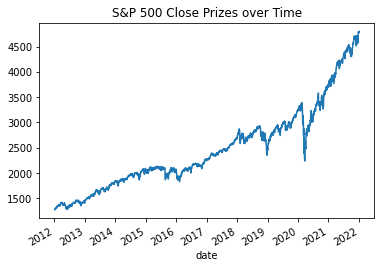

In [133]:
df.close.plot(title="Daily S&P 500 Close Prizes")

In [130]:
df['return'] = df.close - df.open

<AxesSubplot:title={'center':'Daily S&P 500 Return'}, xlabel='date'>

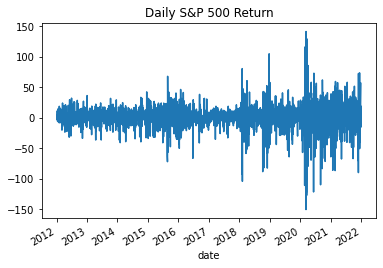

In [135]:
df['return'].plot(title="Daily S&P 500 Return")

### Outliers

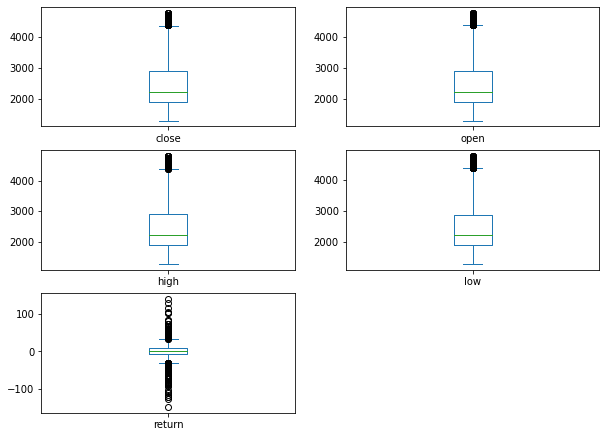

In [136]:
_ = df.plot(kind='box', subplots=True, layout=(7, 2), figsize=(10, 18), sharex=False)

### Correlation Analysis

<AxesSubplot:>

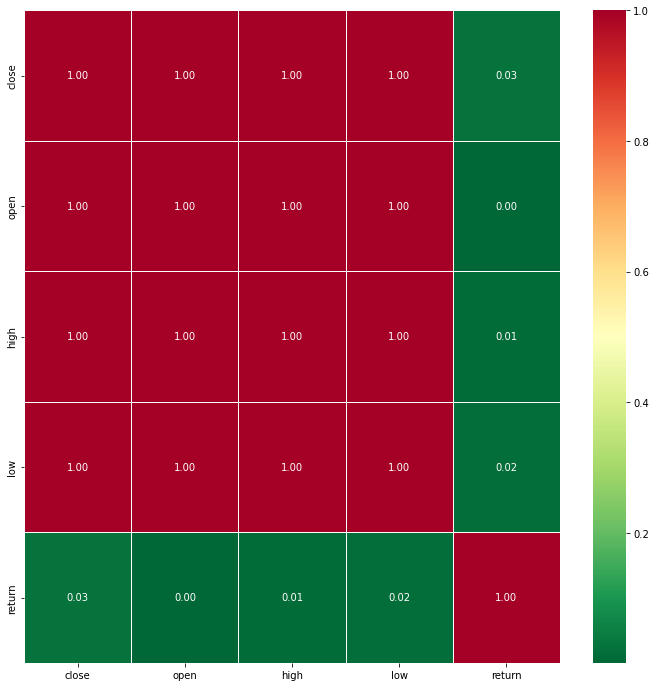

In [137]:
plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn_r', linewidth=0.5, fmt='.2f')

## Data Preprocessing

In [138]:
df['volatility'] = df.high - df.low

<AxesSubplot:title={'center':'Daily S&P 500 Volatility'}, xlabel='date'>

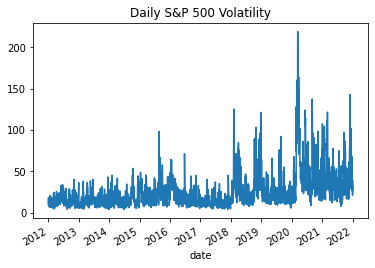

In [140]:
df.volatility.plot(title="Daily S&P 500 Volatility")

### Scaling
We compute the exponentially weighted moving average of every feature (columns). Then, we scale the feature by subtracting the exponentially weighted moving average and dividing by the exponentially weighted standard deviation.

In [141]:
ewdf = df.ewm(halflife=10).mean()

<AxesSubplot:xlabel='date'>

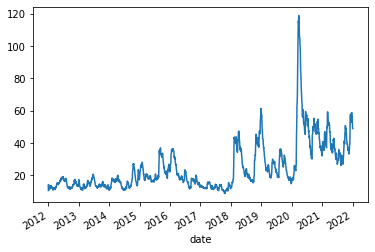

In [142]:
ewdf.volatility.plot()

In [143]:
vewdf = df.ewm(halflife=10).var()

<AxesSubplot:xlabel='date'>

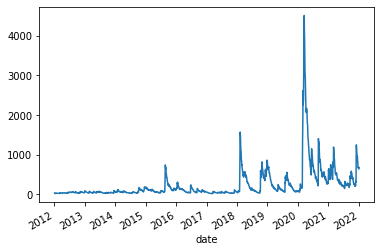

In [144]:
vewdf.volatility.plot()

In [146]:
scaled = df.volatility - ewdf.volatility
scaled = scaled / vewdf.volatility**0.5

<AxesSubplot:xlabel='date'>

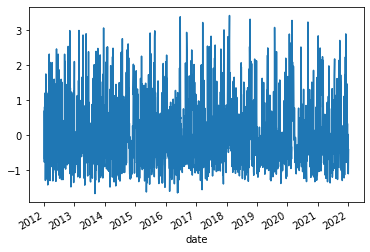

In [147]:
scaled.plot()

In [148]:
df['scaledVolatility'] = ((df['volatility'] - ewdf['volatility'] ) / vewdf['volatility'] **0.5)
df['scaledReturn'] = ((df['return'] - ewdf['return']) / vewdf['return']**0.5)

In [149]:
# Drop NA values that come from the exponential smooting
df = df.dropna()

### Splitting in Training- and Testdata

In [152]:
num_datapoints = df.shape[0]
num_training = int(num_datapoints*0.7)

In [153]:
train_df = df[:num_datapoints]
test_df = df[num_datapoints:]

In [157]:
train_features = ['scaledVolatility', 'scaledReturn']
X_train = train_df.loc[:, train_features].values
y_train = train_df.loc[:, 'scaledReturn'].values

In [158]:
# Verify the shapes of X_train and y_train
print(X_train.shape)
print(y_train.shape)

(2553, 2)
(2553,)


### Reshaping (to fit into the network)

In [159]:
# Expand X_train to have 3 dimensions
X_train_reshaped = np.expand_dims(X_train, axis=1)

In [161]:
# Transform data into a sequences
X_train_sequences = np.split(X_train_reshaped, X_train_reshaped.shape[0]/10, axis=0)
X_train_sequences = np.concatenate(X_train_sequences, axis=1)

ValueError: array split does not result in an equal division

## Implementing Models

### Recurrent Neural Network

### LSTM Network